In [215]:
import seaborn as sns
import numpy as np
import math
from bs4 import BeautifulSoup
import re
import pandas as pd
import glob
import trueskill as ts
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600
mpl.rcParams.update({'axes.titlesize': 'large'})
mpl.rcParams.update({'axes.labelsize': 'large'})

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler




# Set up for importing files
This part is for creating the final spreadsheet to work with. No need to run anything in this section until the next bolded section, unless you are interested in making a new dataset.

To make a new dataset, simply drop all your files into a folder and replace the "file_list" variable with the folder path. The For loop will load all of the files in that folder and make a big dataframe (aka spreadsheet).

In [229]:
# Set up for file import. Change the text in glob.glob to the file directory you're interested in.
file_list = glob.glob("stork_2015/*.html")
d = {}

overall_vars = ['Date', 'Map', 'Time', 'BE', 'DS']
winner_cols = ['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']
loser_cols = ['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']
col_list = overall_vars + winner_cols + loser_cols

In [230]:
df = pd.DataFrame()

In [231]:
stats_list = [u'Player', u'Rating', u'K/D', u'CG', u'Plas', u'Disc', u'Xplosv', u'Laser', u'Mortar', u'Trt', \
              u'Suic', u'TK', u'CKill', u'Grb', u'Pckup', u'Drp', u'Ret', u'Stdoff Ret', u'Assists', u'Cap']

In [232]:
# Import html files

# Count determines the MatchID and increases by one for each iteration of the for loop.
count = 0

for f in file_list:
    dfs = pd.read_html(f)
    
    # Two tables contained in each html
    time_table = dfs[0]
    stats_table = dfs[1]
    
    # Use time_table info
    time_table.columns = ['Player', 'Obs_time', 'BE_time', 'DS_time', 'Flag_time']
    time_table = time_table.dropna()
    time_table = time_table.drop(time_table.index[0])
    time_table = time_table[~time_table['Player'].str.contains('Enemy Flag Home|Enemy Flag in Field|BE Totals|DS Totals')]
    time_table['Obs_time'] = time_table['Obs_time'].str.split(':').apply(lambda x: int(x[0]))
    time_table['BE_time'] = time_table['BE_time'].str.split(':').apply(lambda x: int(x[0]))
    time_table['DS_time'] = time_table['DS_time'].str.split(':').apply(lambda x: int(x[0]))
    time_table['Flag_time'] = time_table['Flag_time'].str.split(':').apply(lambda x: int(x[0]))

    time_table['BE Team'] = time_table['BE_time'].apply(lambda x: 1 if x > 0 else 0)
    time_table['DS Team'] = time_table['DS_time'].apply(lambda x: 1 if x > 0 else 0)
    time_table['Team'] = time_table['BE Team'].apply(lambda x: 'BE' if x > 0 else 'DS')

    BE_players = list(time_table[time_table['BE Team'] == 1]['Player'])
    DS_players = list(time_table[time_table['DS Team'] == 1]['Player'])

    # Use stats_table info to add player stats
    stats_table.columns = stats_list
    stats_table = stats_table.dropna()
    stats_table = stats_table.drop(stats_table.index[0])
    stats_table = stats_table[~stats_table['Player'].str.contains('Match Stats|BE Totals|DS Totals')]

    # merge time_table and stats_table
    table = pd.merge(stats_table, time_table, on = 'Player', how = 'left')
    table = table.drop(['Plas', 'Laser', 'Mortar', 'Trt'], axis = 1)

    # get overall match info
    d[f] = BeautifulSoup(open(f), "html5lib")
    spans = d[f].find_all('span', {'class' : 'value'})
    lines = [span.get_text() for span in spans]
    tds = d[f].find_all('td', {'class' : 't'})
    
    table['Date'] = lines[0]
    table['Map'] = lines[1]
    table['Match_time'] = lines[2]
    table['Match_time'] = table['Match_time'].str.split(':').apply(lambda x: int(x[0]))
    table['BE Score'] = lines[3]
    table['DS Score'] = lines[4]
    table['MatchID'] = count
    
    # Find the match winner
    if lines [3] > lines[4]:
        result = 'BE'
    if lines[3] < lines[4]:
        result = 'DS'
    if lines[3] == lines[4]:
        result = 'Tie'
    table['Match Winner'] = result
    
    table['Match_type'] = 'pub'
    if 9 <= table.shape[0] <= 12:
        table['Match_type'] = 'maybe pickup'
    if  table.shape[0] == 10:
        table['Match_type'] = 'pickup'
    
    count += 1
    
    # Combine each table into the big dataframe
    df = pd.concat([df, table])

In [233]:
# Feature construction
def Win(series):
    if series['Match Winner'] == 'Tie':
        return 'Tie'
    if series['Match Winner'] == series['Team']:
        return 'Win'
    return 'Loss'

# Determine the player's team based on which team player spent the most time on
def Team(series):
    team_possibility = ['BE', 'DS', 'Obs']
    times = [series['BE_time'], series['DS_time'], series['Obs_time']]
    return team_possibility[times.index(max(times))]

def rating_per_min(series):
    return int(series['Rating'])/series['Match_time']

def caps_assists(series):
    return (int(series['Cap']) + int(series['Assists']))

def full_map(series):
    return 1 if series['Match_time'] >= 24 else 0

def CKill_per_min(series):
    return float(series['CKill'])/float(series['Match_time'])

def grb_cap_assist_ratio(series):
    if series['caps_assists'] == 0:
        return 0
    else:
        return (float(series['Grb']) / float(series['caps_assists']))
    
def grb_per_min(series):
    return float(series['Grb']) / float(series['Match_time'])

df['Win'] = df.apply(Win, axis = 1)
df['Team'] = df.apply(Team, axis = 1)
df['rating_per_min'] = df.apply(rating_per_min, axis = 1)
df['caps_assists'] = df.apply(caps_assists, axis = 1)
df['full_map'] = df.apply(full_map, axis = 1)
df['CKill_per_min'] = df.apply(CKill_per_min, axis = 1)
df['grb_cap_assist_ratio'] = df.apply(grb_cap_assist_ratio, axis = 1)
df['grb_per_min'] = df.apply(grb_per_min, axis = 1)

functions = [Win, Team, rating_per_min, caps_assists, CKill_per_min, grb_cap_assist_ratio, grb_per_min]

for func in functions:
    df[str(func)] = df.apply(func, axis = 1)

In [234]:
df['kills'] = df['K/D'].str.rpartition('/')[0]
df['deaths'] = df['K/D'].str.rpartition('/')[2]
df['disc_kills'] = df['Disc'].str.rpartition('/')[0]
df['disc_deaths'] = df['Disc'].str.rpartition('/')[2]
df['gren_kills'] =  df['Xplosv'].str.rpartition('/')[0]
df['gren_deaths'] = df['Xplosv'].str.rpartition('/')[2]
df['cg_kills'] =  df['CG'].str.rpartition('/')[0]
df['cg_deaths'] = df['CG'].str.rpartition('/')[2]

In [235]:

weapon_cols = ['Grb', 'Pckup', 'CKill', 'Ret', 'kills', 'deaths', 'disc_kills', 'disc_deaths', 'gren_kills', 'gren_deaths', 'cg_kills', 'cg_deaths']
df[weapon_cols] = df[weapon_cols].apply(pd.to_numeric, errors = 'coerce')

In [236]:
def kills_per_min(series):
    return float(series['kills']) / float(series['Match_time'])

def disc_per_min(series):
    return float(series['disc_kills']) / float(series['Match_time'])

def cg_per_min(series):
    return float(series['cg_kills']) / float(series['Match_time'])

def perc_flag_time_of_match(series):
    return float(series['Flag_time']) / float(series['Match_time'])

def returns_per_min(series):
    return float(series['Ret']) / float(series['Match_time'])

df['kills_per_min'] = df.apply(kills_per_min, axis = 1)
df['disc_per_min'] = df.apply(disc_per_min, axis = 1)
df['cg_per_min'] = df.apply(cg_per_min, axis = 1)
df['perc_flag_time_of_match'] = df.apply(perc_flag_time_of_match, axis = 1)
df['returns_per_min'] = df.apply(returns_per_min, axis = 1)

In [237]:
def pickup_per_min(series):
    return float(series['Pckup']) / float(series['Match_time'])

def perc_flag_time_grab_ratio(series):
    if series['Grb'] == 0:
        return series['perc_flag_time_of_match'] / 1
    return series['perc_flag_time_of_match'] / series['Grb']

def pickups_minus_grabs(series):
    return pd.to_numeric(series['Pckup'] - series['Grb'])

df['pickup_per_min'] = df.apply(pickup_per_min, axis = 1)
df['perc_flag_time_grab_ratio'] = df.apply(perc_flag_time_grab_ratio, axis = 1)
df['Pckup'] = df['Pckup'].apply(pd.to_numeric)
df['ckills_returns'] = df['CKill'] + df['Ret']
df['pickups_minus_grabs'] = df.apply(pickups_minus_grabs, axis = 1)

In [238]:
df = pd.merge(df, df.groupby(['MatchID', 'Team']).agg({'Grb':'sum'}).reset_index().rename(columns = {'Grb': 'Total Grabs'}), \
         on = ['MatchID', 'Team'], how = 'left')
         
df['perc_grabs'] = df['Grb'] / df['Total Grabs']



In [239]:
home = df.groupby(['MatchID', 'Team'])[['pickups_minus_grabs']].max().reset_index()
home['home'] = 'home'

df = pd.merge(df, home, on = ['MatchID', 'Team', 'pickups_minus_grabs'], how = 'left')

chaser = df.groupby(['MatchID', 'Team'])[['ckills_returns']].max().reset_index()
chaser['chaser'] = 'chaser'

df = pd.merge(df, chaser, on = ['MatchID', 'Team', 'ckills_returns'], how = 'left')


cappers = df.groupby(['MatchID', 'Team'])['perc_grabs'].nlargest(2).reset_index()
cappers['capper'] = 'capper'
cappers

df = pd.merge(df, cappers[['MatchID', 'Team', 'perc_grabs', 'capper']], on = ['MatchID', 'Team', 'perc_grabs'], how = 'left')

def position(series):
    if series['home'] == 'home':
        return 'home'
    if (series['chaser'] == 'chaser') | (series['Grb'] < 2 ):
        return 'chaser'

    if series['capper'] == 'capper':
        return 'capper'
    return 'lo'
df['position'] = df.apply(position, axis = 1)

In [240]:
df = df.drop_duplicates(subset = ['MatchID', 'Team', 'Player'])
df.to_pickle('stork_pickle_2015.p')

In [241]:
df

Player Rating    K/D     CG   Disc Xplosv Suic    TK  \
0               BBK-HeaDCReePS   1689   32/8    0/0   22/5   10/3   33   7/2   
1                bizzy is best   1329  16/23    0/0  11/16    5/7   13   0/2   
2                     maverick    896  24/17    0/0  20/16    4/1   28   1/5   
3                  desertstorm    881  18/17    0/0  10/13    8/4   22   4/0   
4                     S!GHborg    321    4/7    0/0    2/5    2/2   15   1/2   
5                       MaLicE    308    7/6    0/0    6/4    1/2    5   0/1   
6                  |SuC| nav0x    674  13/23    0/0   8/20    5/3   17   3/3   
7              [bdk] darkpiece   1230  11/20    0/0   9/12    2/8   21   3/1   
8                         mavi    975  23/15    0/0  15/11    8/4   30   3/6   
9                    pineapple    704  12/13    0/0   11/8    1/5   15   3/2   
10                          <2    989  19/23    0/0  15/14    4/9   18   1/2   
11                   BBK-juice      0    0/0    0/0    0/0    0/0    0   0/0   
12                     IceHawk    -24    1/7    0/0    1/5    0/2   12   1/1   
13                 BBK-IceHawk    690  15/10    0/0    8/7    7/3   21   6/1   
14                TerroriStick    195   2/20    0/0   1/17    1/3    2   0/0   
16            The Morning Star    731  12/12    0/0    8/7    4/5   17   3/0   
18                       figgs    583  14/11    0/0   12/8    2/3   23   1/5   
19                      rtcLL*    810  21/15    0/0   10/6   11/9    7   0/4   
20              BBK-HeaDCReePS    885  18/15    0/0   12/8    6/7   22   2/3   
21                       Sharp    929  14/13    0/0    9/7    5/6   35   2/1   
22                   BBK-cl0wn   1171   6/12    0/0    4/8    2/4   17   0/0   
23                  flagdrop.1   1158  14/11    0/0    9/8    5/3   21   3/1   
24                          <2    829  16/13    0/0   11/8    5/5   19   1/3   
25                    br0n cat    597   6/14    1/0   2/10    3/4   38   2/2   
26                  rat killer    143    2/1    1/0    1/1    0/0    1   0/0   
27               rtcll is best   1789  37/18   13/6   22/8    2/4   34   4/1   
28                 desertstorm    865  12/20    5/7   4/10    3/3   20   2/3   
29              24 fps is best   1072  11/29    0/9    6/8   5/12   20   2/2   
30                 zip is best    652   7/24    0/7   5/13    2/4   26   0/2   
31               lostmysandz:[    997  17/14    1/3    9/9    7/2   30   0/2   
32                        mavi   1339  21/13    9/2    8/8    4/3   43   1/2   
33                         red    539  12/18    3/5    6/8    3/5   22   5/2   
34                   BBK-juice   1273  26/16    5/4   15/9    6/3   27   2/2   
35              BBK-HeaDCReePS   1527  30/14   11/6   12/6    7/2   43   2/2   
36              BBK-HeaDCReePS   2370  50/15   10/2   25/6   15/7   45   1/0   
37                     ice|wtf   1020  15/20    6/7    7/8    2/5   22   1/0   
38                ztun is best   1006  12/27   3/11    5/7    4/9   32   1/1   
39                    maverick   1721  39/27   11/5  17/13   11/9   42   0/1   
40                          <2   1118  20/21    0/6   14/7    6/8   40   0/1   
41                  rat killer    681  20/27    7/8   8/13    5/6   18   3/1   
42                      jasper   1201  18/32    0/8   9/15    9/9   26   1/2   
43              24 fps is best   2597  48/19   20/4    8/9   20/6   45   8/3   
44               bizzy is best   1093  10/36    1/7   7/17   2/12   20   1/3   
45                BBK- i z z a    651  14/22    3/3   9/14    2/5   37   1/5   
46            1101010010101101   1562  28/24  15/12    6/9    7/3   28   2/1   
47                       fdsgg    837  11/19    0/2  10/10    1/7   30   1/1   
48                   bizzy|wtf    240   6/30    2/5   3/15   1/10   21   0/1   
49                    megadeth    165   4/30    0/8   3/13    1/9   19   0/0   
50                    S!GHborg    818  24/16    5/7   12/6    7/3   54   2/2   
51                  Head

# Load Data

In [299]:
df = pd.read_pickle('stork_pickle_2010.p')

In [300]:
# Dicts to translate smurfs into original names

df['Player'] = df['Player'].str.lower()

name_dict = {'s_whicka-wha.cs': "anemix", \
             'pineapple': "rtcll", \
             'flagdrop\.1|flagdrop|robotparts|jideuregagon': 'opsayo', \
             'winter|<2|blank|coral|<#': 'dare', \
             'ice\|wtf\.1|ice\|wtf': 'icehawk', \
             's!ghborg|lonely boy': 'lost', \
             'zOp_': 'zip', \
             '\$quash|jasper|sharp' : 'sharp|laptop', \
             'bbk-cl0wn|i am billy mays': 'cl0wn', \
             '1101010111011001|0010101010100010|<-AoA->muscles|0010111101100001|10010110101001|1101010010101101': 'snow', \
             '<-aoa->mylilpony': 'thump', \
             'shamepiece': 'darkpiece', \
             '<-aoa->mad4bad': 'bins', \
             '[||]=ofjustice==': 'stork', \
             'natemix': 'chexmix', \
             'carl weathers': 'meph', \
             'rat killer|shrimpy|mushroom': 'orange', \
             '\|\|\|\|\|\|\|\| is best|\|\|\|\|\|\|\|\|\|\|\|\|\|\|\|\||skylake is best|24 fps is best': 'sleep'}


player_dict = ['stork', 'sleep', 'jasper', 'headcreeps', 'gim', 'icehawk', 'rtcll', 'fire', 'cyanide', 'mun', 'disci', 'dutch', \
               'stim', 'fis', 'opsayo', 'danky', 'thump', 'lost', 'sword', 'cyclops', 'skillz', \
               'anemix', 'tool', 'maverick', 'killa j', 'masterace', 'xui', 'dare', 'softski', 'sharp', 'jag', 'carn', \
               'fx', 'joe', 'jm', 'bizzy', 'jjwtay', 'nonreg', 'brouhaha', 'izza', 'panama', 'vanster', 'alarik', \
               'zepto', 'jingjang', 'drg0', 'disk', 'linchy', 'leo', 'darksoul','cider','izod', 'mouse', 'curry smash', \
               'solidsnake', 'xui', 'snow', 'a panda', 'raven', 'coza', 'milk', 'xoo', 'x00', 'xu1', 'mitsu', 'sabre', \
               'kevin', 'hyung', 'ucl', 'pr', 'luck', 'soulroll', 'pikaboo', '2:37', 'clu', 'meph', 'eliminator', 'slush', \
               'nav0x', 'navox', 'jag', 'humps', 'zip', 'ztun', 'bins', 'darkpiece', 'juic', 'i z z a', 'agnostick', 'br0n', \
               'king of kings', 'snow', 'cl0wn', 'budweiser', 'jingjang', 'skisonic', 'csq', 'groove', 'aw man', 'justice', 'cycl0p', 'natemix', 'chernobyl', 'zoo', 'zla', 'i z z a']

for player in player_dict:
    df['Player'].replace({'(.*)' + player + '(.*)': player}, regex = True, inplace = True)

dict_2010_regex = {
                    'hyung|ucl|softski|undercover lover|opsayoucl|juic|jideuraegon|soft': 'opsayo', \
                    'tinkerbell|black kid|aw man|vegetable hunter|critique': 'dare', \
                    'king of kings|the morning star': 'sleep', \
                    'cider': 'anemix', \
                    'stdn0va': 'carn', \
                    'budweiser': 'navox', \
                    'youjustgotbb\'d': 'the truth', \
                    'csq|skisonic|soulroll':'bk', \
                    'headcreeps|justice|bigstop|throughthenever|dblbrtlcirclepit|ridethelightning': 'stork', \
                    'lonely boy': 'lost', \
                    'coza|cycl0p|da cozja' : 'cyclops', \
                    'pikabooz':'danky', \
                    'zla|rla': 'rizla', \
                    '-w- _kill_|_kill_': 'skillz', \
                    'milk|thump': 'milk-man', \
                    'nav0x': 'navox', \
                    'zeptard|septo': 'zepto', \
                    '\$wordfish|xiphias|sword': 'swordfish', \
                    'xoo|x00|xu1|zoo': 'xui', \
                    'america=cdc|dyc': 'snow', \
                    'thatssoraven|thatsnotraven|\' \* \' genewilder': 'lix', \
                    '\*iw\*joellama5000|jm|joe': 'joemamma', \
                    'nihility|-\)r\(- fx': 'fx', \
                    'luck|laptop-n-a-1/2': 'kevin', \
                    'i z z a': 'izza', \
                    'bo\$\$dogg|\' \* \' fettuccine': 'fettuccine', \
                    'sdt-evolvo': 'evolvo', \
                    '2good@tribes\.com|fucking magnets\?': 'copacetic',\
                    's_ashimiboy\.cs': 'solidsnake', \
                    'drg0': 'drg0n', \
                    'max power': 'kove', \
                    'monet|a panda': 'fis', \
                    'desert-storm|ztun': 'desertstorm', \
                    'pajama jama': 'panama'}

df.replace({"Player": dict_2010_regex}, regex = True, inplace = True)
df.replace({"Player": name_dict}, regex = True, inplace = True)

df['Player'].value_counts()

stork                       319
opsayo                      246
sleep                       222
lost                        177
milk-man                    154
fis                         152
dare                        108
cyclops                     100
skillz                       98
chexmix                      97
maverick                     88
xui                          88
rtcll                        84
anemix                       81
masterace                    73
tool                         72
zepto                        67
disk                         52
raven                        48
joemamma                     46
sharp|laptop                 43
danky                        42
bk                           41
snow                         40
malice                       36
jag                          35
carn                         34
td|segarob                   30
swordfish                    27
navox                        27
solidsnake                   26
-sb- mag

In [301]:
weapon_cols = ['Grb', 'grb_per_min','Pckup', 'CKill', 'Ret', 'kills', 'deaths', 'disc_kills', \
               'disc_deaths', 'gren_kills', 'gren_deaths', 'cg_kills', 'cg_deaths']
df[weapon_cols] = df[weapon_cols].apply(pd.to_numeric, errors = 'coerce')

df[['kills_per_min', 'disc_per_min', 'CKill_per_min', 'grb_cap_assist_ratio', 'Cap', 'CKill']] = \
df[['kills_per_min', 'disc_per_min', 'CKill_per_min', 'grb_cap_assist_ratio', 'Cap', 'CKill']].apply(pd.to_numeric)

# Exploratory Statistics

In [302]:
df.drop_duplicates(subset = ['MatchID']).groupby(['Map', 'Match Winner']).size()

Map                  Match Winner
DangerousCrossingLT  BE              77
                     DS              78
DayFallLT            BE               1
EmeraldValleyLT      BE               1
HildebrandLT         BE              28
                     DS              55
                     Tie              1
RaindanceLT          BE               1
StonehengeLT         BE              60
                     DS              57
                     Tie              1
raindanceLT          BE               2
dtype: int64

## Defense

In [303]:
chasers = df[df['position'] == 'chaser']
temp3 = chasers['Player'].isin(chasers['Player'].value_counts().index[chasers['Player'].value_counts() > 10])

chasers[temp3].groupby(['Player'])[['rating_per_min', 'CKill_per_min']].mean().sort_values(by = 'CKill_per_min', ascending = False)


rating_per_min  CKill_per_min
Player                                  
stork           74.638616       0.880192
snow            70.370482       0.861657
opsayo          70.235091       0.781074
anemix          69.578498       0.746244
rtcll           68.213899       0.732823
sleep           56.761249       0.660726
dare            54.064794       0.644919
lost            57.524999       0.644206
milk-man        56.324220       0.631793
disk            51.620777       0.619585
danky           59.985632       0.618451
masterace       52.950417       0.605411
kelo            33.729456       0.394851

# Set up for matches

In [304]:
winner_cols = [u'WPlayer1', u'WPlayer2', u'WPlayer3', u'WPlayer4', u'WPlayer5', u'WPlayer6']
loser_cols = [ u'LPlayer1', u'LPlayer2', u'LPlayer3', u'LPlayer4', u'LPlayer5', u'LPlayer6', u'LPlayer7']

In [305]:
temp1 = df[df['Team'] != 'Obs']
temp1 = temp1.groupby(['MatchID', 'Win'])['Player'].apply(list)
temp1 = temp1.unstack('Win')

In [306]:
temp1

Win                                                   Loss  \
MatchID                                                      
0              [kove, *iw*n9ne, milk-man, fettuccine, xui]   
1             [anemix, opsayo, masterace, sleep, maverick]   
2        [sharp|laptop, maverick, sleep, darksoul, anemix]   
3                     [dare, sleep, disk, milk-man, stork]   
4                  [dare, timecode, malice, opsayo, stork]   
5              [masterace, tsi, copacetic, skillz, anemix]   
6             [malice, powerless rise, disk, maverick, bk]   
7              [lost, mortal wombat, opsayo, kelo, malice]   
8         [lost, stork, sharp|laptop, copacetic, joemamma]   
9        [chexmix, anemix, milk-man, joemamma, cyclops,...   
10       [shortroute, bk, austria united, fis, skillz, ...   
11       [sleep, desertstorm, maverick, apache chief, s...   
12       [anemix, alarik, lost, kill-switch, sharp|laptop]   
13            [_legend_ki11er_, lost, hated, stork, kevin]   
14       [stim, sir krs-one, swordfish, sir bobb mc0bb,...   
15       [|t|h|e| |o|n|e|, fis, dr.burnyabad, chexmix, ...   
16                [lost, peter, opsayo, milk-man, cyclops]   
17       [sharp|laptop, masterace, mersine, joemamma, m...   
18                [chexmix, rtcll, lost, joemamma, opsayo]   
19       [td|segarob, zepto, -sb- |__|ofdeath, maverick...   
20                  [lost, timecode, opsayo, dare, skillz]   
21       [[kov]hector, howdougetsliced, disk, sleep, tool]   
22                 [tool, flaire, sleep, opsayo, majestic]   
23                       [fis, xui, cyclops, navox, sleep]   
24       [sleep, timecode, raven, majestic, * psyc]-[oe...   
25                     [cyanide, danky, disk, dare, stork]   
26               [sleep, swordfish, tool, opsayo, chexmix]   
27                  [lost, milk-man, cyclops, tool, stork]   
28       [dolphinbird king, cyclops, milk-man, stork, s...   
29                   [darko, skillz, linchy, anemix, carn]   
30                     [fis, sleep, milk-man, lost, rtcll]   
31              [snow@aces, rtcll, td|segarob, stork, jag]   
32             [maverick, opsayo, psycho[bym], zepto, fis]   
33       [masterace, d o m 3 s t i c, kill-switch, chex...   
34       [-puc-, d o m 3 s t i c, sharp|laptop, danky, ...   
35         [kevin, curry smash, dare, sharp|laptop, stork]   
36       [lost, maverick, skillz, masterace, d o m 3 s ...   
37                   [tool, danky, dare, stork, swordfish]   
38       [bill the butcher, maverick, jag, masterace, s...   
39             [jjwtay, bk, stork, sharp|laptop, joemamma]   
40                   [killa j, xeri., lost, stork, opsayo]   
41       [dare, -----<bzzstgzzt, 1.21 gigawatts, -sb- m...   
42                           [jag, fis, fis, sleep, stork]   
43               [jag, opsayo, skillz, izza, ast| wu-dang]   
44                  [stork, dare, milk-man, opsayo, navox]   
45         [lost, solidsnake, masterace, joemamma, skillz]   
46       [jingjang, joemamma, opsayo, milk-man, fettucc...   
47                [cyclops, disk, opsayo, milk-man, sleep]   
48                       [dare, navox, disk, skillz, fire]   
49       [opsayo, -sb- |__|ofdeath, drg0n, bizzy, sword...   
50                     [lost, disk, snow, o|2gy, milk-man]   
51           [fis, anemix, darksoul, who am i i am u, xui]   
52                [stork, dare, chexmix, rizla, swordfish]   
53                 [sabre, methadone, danky, leo, chexmix]   
54       [chexmix, evolvo, [] noctiferia [], stork, mav...   
55       [xen, kelo, bulbospongiosus, sleep, opsayo, sk...   
56       [fu9ck, kelo, maverick, opsayo, opsayoserve, {...   
57              [sleep, opsayo, jingjang, carn, dr.dugong]   
58        [|v|ector, -{txm}-boots-, chexmix, opsayo, stim]   
59       [-sb- magictoast, -sb- |__|ofdeath, bong man, ...   
60                          [xui, tool, dare, stork, lost]   
61               [xui, -w- cpt.kirk, fis, rtcll, joemamma]   
62                   [xui, evlov

In [307]:
if 'Tie' in temp1.columns:
    temp1 = temp1[['Win', 'Loss']].fillna(temp1['Tie'])
temp1.dropna(inplace = True)

In [308]:
match_df = pd.merge(pd.DataFrame(temp1.Win.values.tolist(), index= temp1.index, columns = winner_cols).reset_index(), \
         pd.DataFrame(temp1.Loss.values.tolist(), index= temp1.index, columns = loser_cols).reset_index(), \
         on = 'MatchID')

match_dict_map = dict(zip(df['MatchID'], df['Map']))
match_dict_date = dict(zip(df['MatchID'], df['Date']))
match_dict_winner = dict(zip(df['MatchID'], df['Match Winner']))
match_df['Map'] = match_df['MatchID'].map(match_dict_map)
match_df['Date'] = match_df['MatchID'].map(match_dict_date)
match_df['Winner'] = match_df['MatchID'].map(match_dict_winner)

match_df = match_df.sort_values(by = 'Date')

In [309]:
match_df['Winner'].value_counts()

DS    190
BE    170
Name: Winner, dtype: int64

# Ratings

#### Choosing a rating system
There are a lot of choices for rating systems. Popular rating systems include elo, glicko2, and trueskill. I opted to use TrueSkill since it's the only one that handles greater than 1v1 cases.

Mu represents the estimate of the true rating of a player. Sigma represents the uncertainty factor regarding the estimate of mu. This is often just as important. A player who won 3 out of 3 games but should have only won 2 out of 3 would have a high mu but would still retain a high sigma (low sigma). The algorithm takes into account whether the teams are stacked by calculating its own estimation of what the outcome of the match should be, based on the initial ratings of the players coming into the match.

Additional details can be found here: [Layman explanation](https://wiki.faforever.com/index.php?title=How_Trueskill_works), [Technical Explanation](https://www.moserware.com/assets/computing-your-skill/The%20Math%20Behind%20TrueSkill.pdf). 

#### Limitations

Ratings here are not final for a couple of reasons. 
* Having smurfs still present provides some inaccuracy, since they are treated as an average player when calculating the probability of team 1 beating team 2.
* Any dataset is limited by the acquirable data. Stork was generous enough to provide his data from 2010 and 2015. 350 and 120 games respectively is a lot of games, but more data is always helpful.



In [310]:
players = set(df['Player'])
players_ts = dict(zip(players, [ts.Rating() for i in players]))
players_ts_time = {player: [] for player in players}

In [311]:
for i, row in match_df.iterrows():
    # Find ratings in dictionary
    winner_list = list(filter(None, list(row[winner_cols])))
    loser_list = list(filter(None, list(row[loser_cols])))
    t1 = [players_ts[player] for player in winner_list]
    t2 = [players_ts[player] for player in loser_list]
    # Get ratings after match
    a, b = (ts.rate([t1, t2], ranks=[0, 1]))
    #print (a,b)

    if row['Winner'] == 'Tie':
        a, b = (ts.rate([t1, t2], ranks=[0, 0]))
    # Update ratings in dictionary (not necessary to split winners and losers, but easier to read and debug)
    for i, player in list(enumerate(winner_list)):
        players_ts[player] = a[i]
        players_ts_time[player].append(a[i].mu)
    for i, player in list(enumerate(loser_list)):
        players_ts[player] = b[i]
        players_ts_time[player].append(b[i].mu)

In [312]:
sorted_rating_list = sorted(((value.mu, key) for (key,value) in players_ts.items()), reverse = True)

In [313]:
sorted_rating_list

[(35.713060654589626, 'snow'),
 (34.94997318474978, 'fx'),
 (34.52039812877285, 'anemix'),
 (33.46053666469051, 'rtcll'),
 (32.24257560027737, 'stork'),
 (31.98319445809137, 'raven'),
 (31.51729163412677, 'sharp|laptop'),
 (31.11351071881846, "child's play"),
 (30.52689704058893, 'kove'),
 (30.517946149654474, 'rizla'),
 (30.410607426477412, 'teleshock'),
 (30.216422199984894, 'opsayo'),
 (30.048575870723905, 'danky'),
 (29.93218797825852, 'pwnravage'),
 (29.69436415115228, 'dark'),
 (29.692953582442446, 'godking'),
 (29.612422283363077, 'chimera'),
 (29.553369329068012, 'e-rock'),
 (29.42760056682018, 'the truth'),
 (29.25436367135269, 'bk'),
 (29.181753893481158, '|sps| marv'),
 (29.177477834693494, 'mega fox'),
 (28.906845177935228, 'm a s o n`'),
 (28.85164794645313, 'bizzy'),
 (28.791554438709515, "' philip traum '"),
 (28.677434868753213, 'grouch_'),
 (28.65083585326903, 'dr.burnyabad'),
 (28.605549511190763, '[abf]-dbag'),
 (28.288131426963584, '[pa*]lilreb'),
 (28.1950894312144

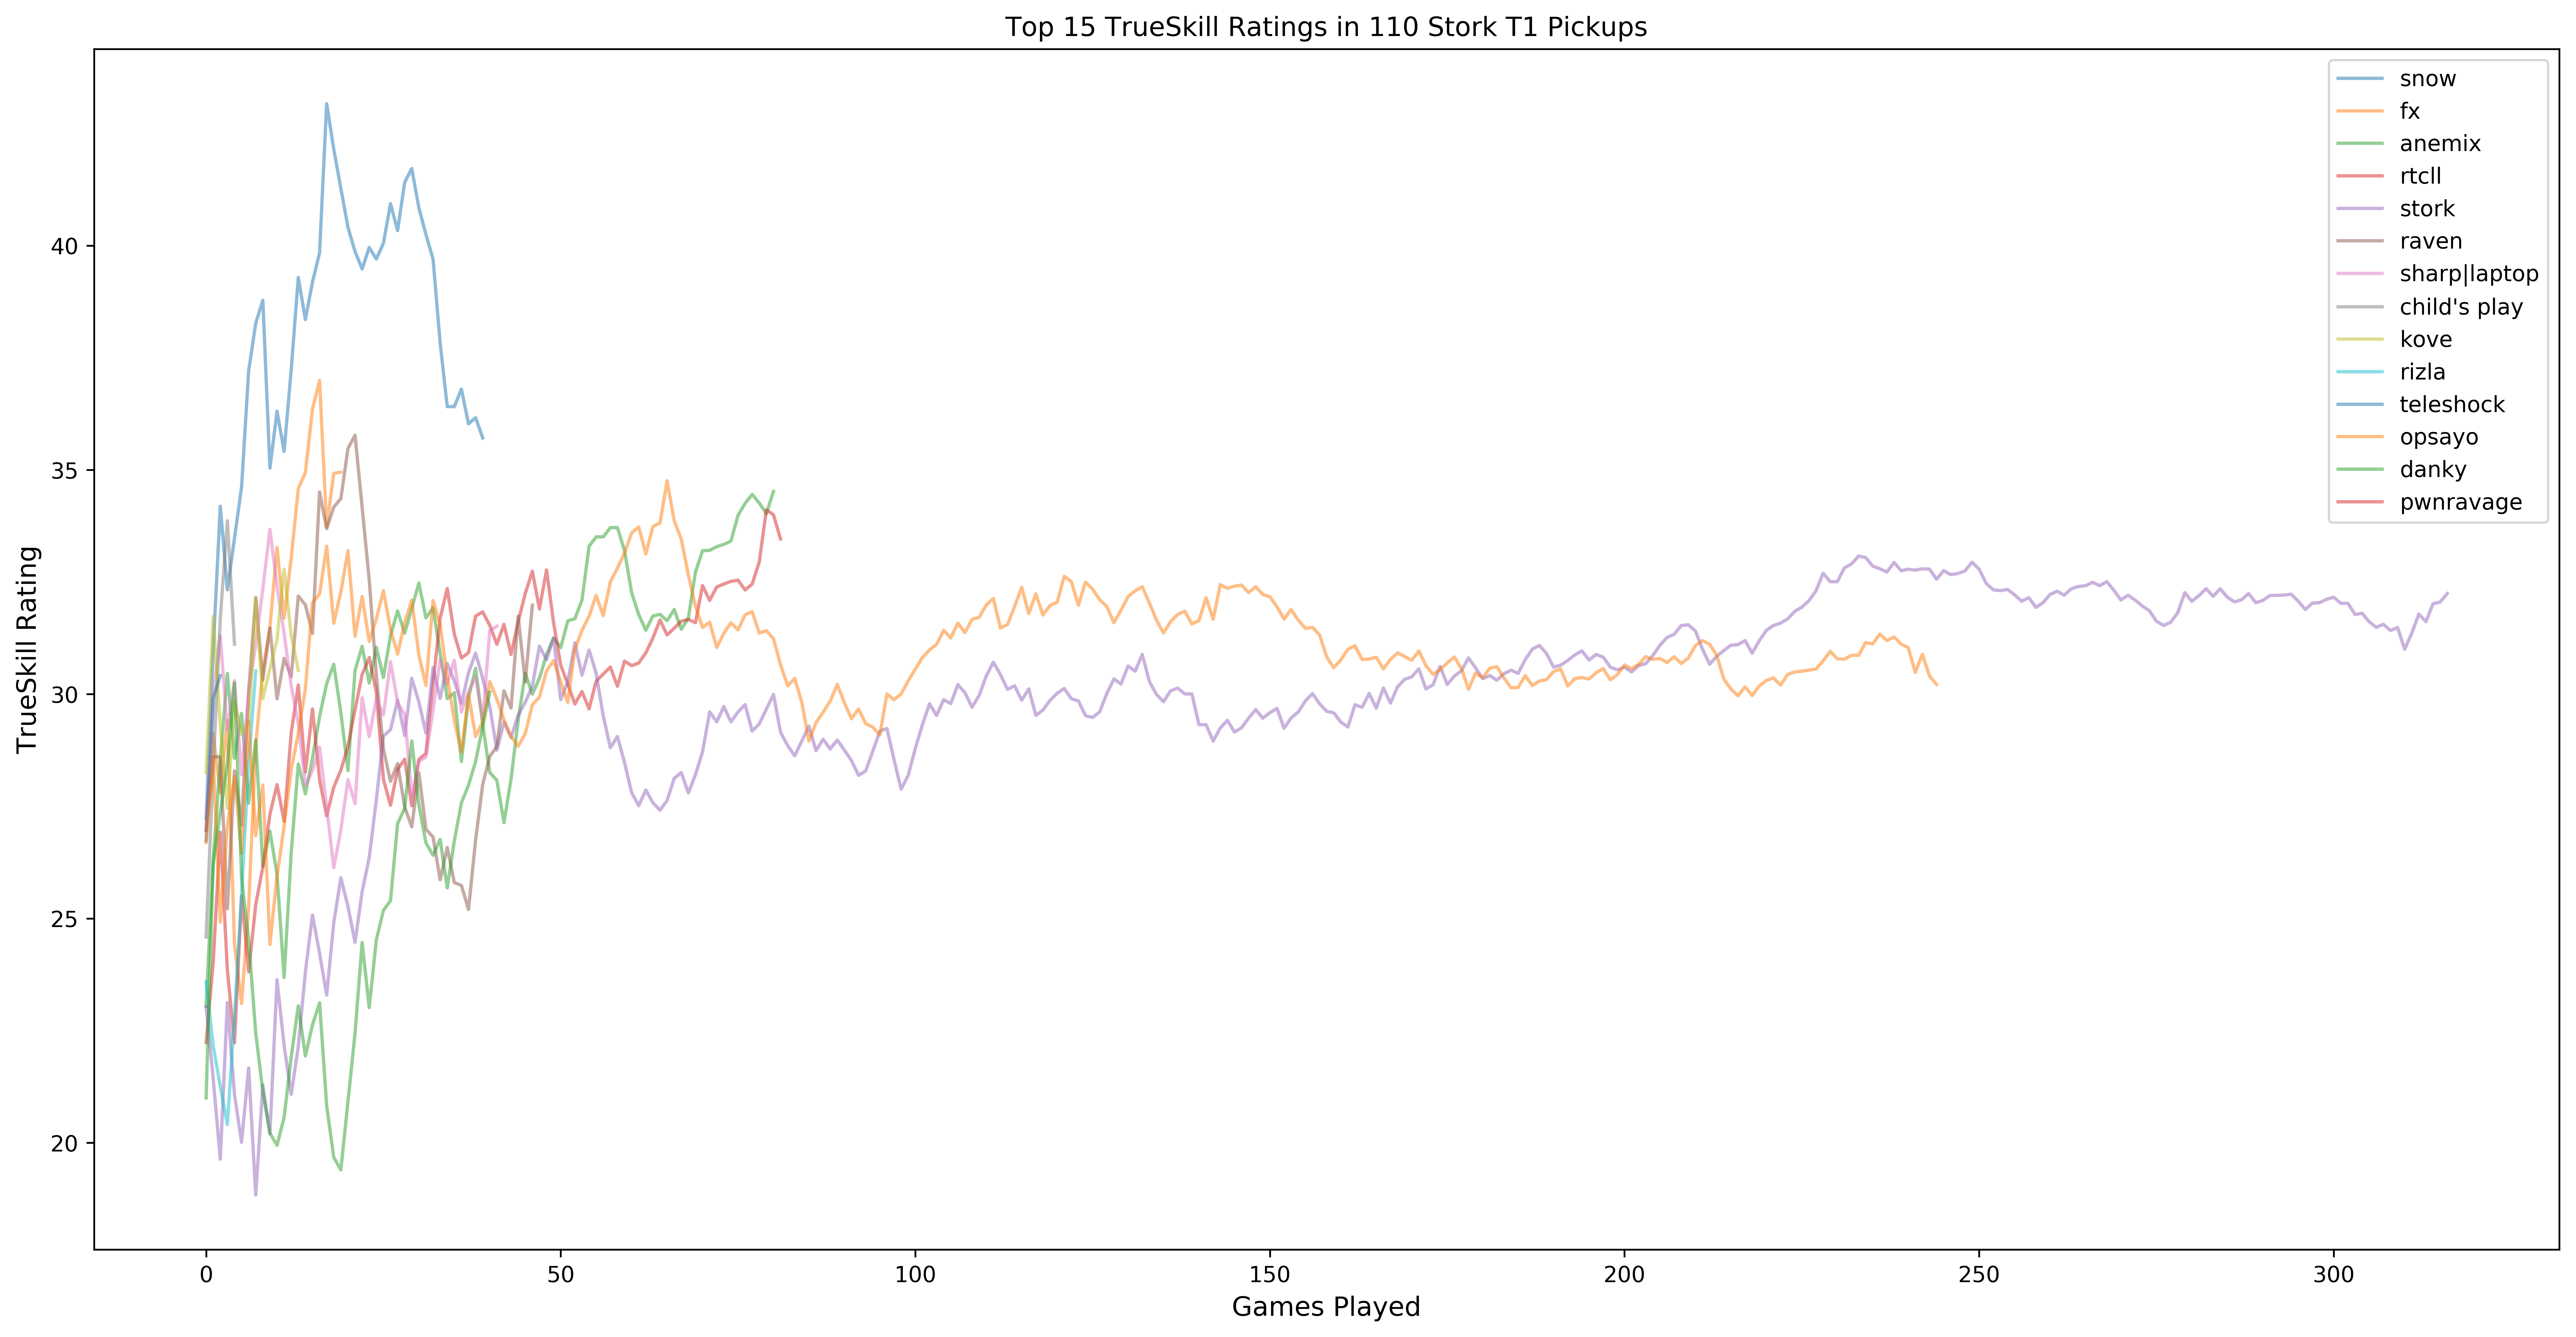

In [314]:
plotted_players = [item[1] for item in sorted_rating_list[0:14]]
plt.figure(figsize=(20,10))
for i, player in enumerate(plotted_players):
    plt.plot(players_ts_time[player], alpha=0.5)
    
plt.title("Top 15 TrueSkill Ratings in 110 Stork T1 Pickups")
plt.xlabel('Games Played')
plt.ylabel('TrueSkill Rating')
plt.legend(plotted_players)
plt.show()

In [315]:
def profile_player(target, position = False, individual = False, partner_list = False, partner = False, \
                   compare_players = False, \
                   opponent_list = False, opponent = False):
    profile_df = match_df[match_df[winner_cols + loser_cols].isin([target]).any(axis = 1)]

    
    print (target + "'s" + " overall record is: " + str(match_df[winner_cols].isin([target]).any(axis = 1).sum()) + " - " + \
           str(match_df[loser_cols].isin([target]).any(axis = 1).sum()))
    
    rank_ts = [(i+1, item[0]) for i, item in enumerate(sorted_rating_list) if item[1] == target][0]
    print (target + ' is ranked ' + str(rank_ts[0]) + ' out of ' + str(len(sorted_rating_list)) + \
           ', with TrueSkill score of ' + str(round(rank_ts[1], 3)) + ' and uncertainty of ' + str(round(players_ts[target].sigma, 3)))
    
    if position is not False:
        profile_df = match_df[match_df['MatchID'].isin(df[(df['Player'] == target) & (df['position'] == position)]['MatchID'])]
        print (target + "'s " + str(position).upper() + " record is: " + str(profile_df[winner_cols].isin([target]).any(axis = 1).sum()) + " - " + \
           str(profile_df[loser_cols].isin([target]).any(axis = 1).sum()))

    record_df = pd.concat([profile_df[profile_df[winner_cols].isin([target]).any(axis = 1)]['Map'].value_counts(), \
                           profile_df[profile_df[loser_cols].isin([target]).any(axis = 1)]['Map'].value_counts()], axis = 1)
    record_df.columns = ['Wins', 'Losses']
    record_df.fillna(0, inplace = True)
    record_df.Wins = record_df.Wins.astype(int)
    record_df.Losses = record_df.Losses.astype(int)

    print (record_df)

    if individual:
        target_df = df[df['Player'].str.contains(target) & \
                       (~df['Map'].str.contains('EmeraldValleyLT|SnowblindLT|DayFallLT|RaindanceLT|BastardForgeLT', case = False))]
        f, axes = plt.subplots(2, 3, figsize=(15,15))
        x_val = 'Map'
        if position is not False:
            hue_val = 'position'
            sns.boxplot(x = x_val, y = 'disc_per_min', hue = hue_val, data = target_df, ax = axes[0][0])
            sns.boxplot(x = x_val, y = 'cg_per_min', hue = hue_val, data = target_df, ax = axes[0][1])
            sns.boxplot(x = x_val, y = 'kills_per_min', hue = hue_val, data = target_df, ax = axes[0][2])
            sns.boxplot(x = x_val, y = 'rating_per_min', hue = hue_val, data = target_df, ax = axes[1][0])
            sns.boxplot(x = x_val, y = 'CKill_per_min', hue = hue_val, data = target_df, ax = axes[1][1])
            sns.boxplot(x = x_val, y = 'returns_per_min', hue = hue_val, data = target_df, ax = axes[1][2])
        if position is False:
            sns.boxplot(x = x_val, y = 'disc_per_min', data = target_df, ax = axes[0][0])
            sns.boxplot(x = x_val, y = 'cg_per_min', data = target_df, ax = axes[0][1])
            sns.boxplot(x = x_val, y = 'kills_per_min', data = target_df, ax = axes[0][2])
            sns.boxplot(x = x_val, y = 'rating_per_min', data = target_df, ax = axes[1][0])
            sns.boxplot(x = x_val, y = 'CKill_per_min', data = target_df, ax = axes[1][1])
            sns.boxplot(x = x_val, y = 'returns_per_min', data = target_df, ax = axes[1][2])


    if compare_players is not False:
        if position in ('capper', 'lo'):
            temp = df[df['Player'].str.contains(compare_players + '|' + target) & \
                      (df['position'] == 'capper') & ~(df['Map'].str.contains('EmeraldValleyLT|SnowblindLT|DayFallLT|RaindanceLT|BastardForgeLT', case = False))]

            f, axes = plt.subplots(2, 2, figsize=(13,13))

            sns.boxplot(x = 'Map', y = 'kills_per_min', hue = 'Player', data = temp, ax = axes[0][0])
            sns.boxplot(x = 'Map', y = 'grb_per_min', hue = 'Player', data = temp, ax = axes[0][1])
            sns.boxplot(x = 'Map', y = 'perc_flag_time_of_match', hue = 'Player', data = temp, ax = axes[1][0])
            sns.boxplot(x = 'Map', y = 'grb_cap_assist_ratio', hue = 'Player', data = temp, ax = axes[1][1])

        if position in ('home', 'chaser'):
            temp2 = df[df['Player'].str.contains(compare_players + '|' + target) & \
                       (df['position'] == position) & ~(df['Map'].str.contains('EmeraldValleyLT|SnowblindLT|DayFallLT|RaindanceLT|BastardForgeLT', case = False))]

            f, axes = plt.subplots(2, 3, figsize=(15,15))

            sns.boxplot(x = 'Map', y = 'disc_per_min', hue = 'Player', data = temp2, ax = axes[0][0])
            sns.boxplot(x = 'Map', y = 'cg_per_min', hue = 'Player', data = temp2, ax = axes[0][1])
            sns.boxplot(x = 'Map', y = 'kills_per_min', hue = 'Player', data = temp2, ax = axes[0][2])
            sns.boxplot(x = 'Map', y = 'rating_per_min', hue = 'Player', data = temp2, ax = axes[1][0])
            sns.boxplot(x = 'Map', y = 'CKill_per_min', hue = 'Player', data = temp2, ax = axes[1][1])
            sns.boxplot(x = 'Map', y = 'returns_per_min', hue = 'Player', data = temp2, ax = axes[1][2])


    winner_partners_dict = Counter(profile_df[profile_df[winner_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    loser_partners_dict = Counter(profile_df[profile_df[loser_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    
    if partner_list is not False:
        ds = [winner_partners_dict, loser_partners_dict]
        d = {}
        for k in winner_partners_dict:
            d[k] = tuple(d[k] for d in ds)
            
        for k in loser_partners_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing with these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))

    if partner is not False:
        print ('\n' + target + ' has ' + str(winner_partners_dict[partner]) + ' wins and ' + \
               str(loser_partners_dict[partner]) + ' losses with ' + partner)
        
    winner_vs_opponents_dict = Counter(profile_df[profile_df[winner_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    loser_vs_opponents_dict = Counter(profile_df[profile_df[loser_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    
    if opponent_list is not False:
        ds = [winner_vs_opponents_dict, loser_vs_opponents_dict]
        d = {}
        for k in winner_vs_opponents_dict:
            d[k] = tuple(d[k] for d in ds)
        for k in loser_vs_opponents_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing against these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))

    if opponent is not False:
        print ('\n' + target + ' has ' + str(winner_vs_opponents_dict[opponent]) + ' wins ' + \
               str(loser_vs_opponents_dict[opponent]) + ' losses against ' + opponent)

# Use this function to play around with seeing statistics

* Player must exist in the spreadsheet or you'll get an error.
* Set to False if you don't want that info.

In [317]:
profile_player('stork', position = 'chaser', individual = True, partner_list = False,  partner = 'rtcll', \
               compare_players = 'sleep|rtcll', \
               opponent_list = False, opponent = 'rtcll')

stork's overall record is: 178 - 137
stork is ranked 5 out of 267, with TrueSkill score of 32.243 and uncertainty of 1.682
stork's CHASER record is: 61 - 52
                     Wins  Losses
DangerousCrossingLT    22      28
DayFallLT               1       0
HildebrandLT           15      12
StonehengeLT           22      12
raindanceLT             1       0


/Users/francisloh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  



stork has 2 wins and 0 losses with rtcll

stork has 5 wins 7 losses against rtcll


# Predicting Wins

## TrueSkill

In [262]:
import itertools
import math
BETA = 4.1666
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    trueskill = ts.global_env()
    return trueskill.cdf(delta_mu / denom)


In [266]:
#win_probability([players_ts['stork'], players_ts['opsayo'], players_ts['cl0wn'], players_ts['fire'], players_ts['izza']],\
#                [players_ts['sharp|laptop'], players_ts['rtcll'], players_ts['sleep'], players_ts['bizzy'], players_ts['jag']])

KeyError: 'clown'

## Supervised Learning

In [267]:
df[['Rating', 'CKill']] = df[['Rating', 'CKill']].apply(pd.to_numeric)

In [268]:
outcome_df = df[['MatchID', 'Match Winner', 'Map']].drop_duplicates()
def Match_Loser(series):
    if series['Match Winner'] == 'BE':
        return 'DS'
    if series['Match Winner'] == 'DS':
        return 'BE'
    return 'Tie'
outcome_df['Match_Loser'] = outcome_df.apply(Match_Loser, axis = 1)

In [269]:
calc_df = df.groupby(['MatchID', 'Team'])[['Rating', 'CKill']].agg({np.sum, np.std, np.ptp}).unstack()
calc_df.columns = [' '.join(col).strip() for col in calc_df.columns.values]


In [270]:
merged_df = pd.merge(calc_df, outcome_df, on = 'MatchID', how = 'left')

In [271]:
def BE_DS_sum_rating_difference(series):
    return series['Rating sum BE'] - series['Rating sum DS']

def BE_DS_std_rating_difference(series):
    return series['Rating std BE'] - series['Rating std DS']

def BE_DS_ptp_rating_difference(series):
    return series['Rating ptp BE'] - series['Rating ptp DS']

merged_df['BE_DS_sum_rating_difference'] = merged_df.apply(BE_DS_sum_rating_difference, axis = 1)
merged_df['BE_DS_std_rating_difference'] = merged_df.apply(BE_DS_std_rating_difference, axis = 1)

merged_df['BE_DS_ptp_rating_difference'] = merged_df.apply(BE_DS_ptp_rating_difference, axis = 1)

In [272]:
merged_df = merged_df[(merged_df['Match Winner'] != 'Tie') & \
          (~merged_df['Map'].str.contains('DayFallLT|EmeraldValleyLT|RaindanceLT', case = False))]
                                                  
merged_df['Match Winner'].replace({'BE': 1, 'DS': 0}, inplace = True)

In [273]:
train_cols = ['BE_DS_sum_rating_difference', 'BE_DS_std_rating_difference', 'BE_DS_ptp_rating_difference', 'Map']

In [274]:
dummy_df = pd.get_dummies(merged_df[train_cols])

In [275]:
X = np.array(dummy_df)
X[:][0:2] = StandardScaler().fit_transform(X[:][0:2])

In [276]:
y = np.array(merged_df['Match Winner'])

In [277]:
from sklearn.cross_validation import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.8)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

from sklearn.metrics import accuracy_score

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9295774647887324

In [278]:
y2_model

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0])

In [279]:
len(y2_model)

71

In [283]:
import statsmodels.formula.api as sm

In [284]:
logit = sm.Logit(merged_df['Match Winner'], dummy_df)

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.240939
         Iterations 8


In [285]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Match Winner   No. Observations:                  355
Model:                          Logit   Df Residuals:                      349
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Aug 2018   Pseudo R-squ.:                  0.6512
Time:                        12:28:17   Log-Likelihood:                -85.533
converged:                       True   LL-Null:                       -245.19
                                        LLR p-value:                 7.060e-67
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
BE_DS_sum_rating_difference     0.0022      0.000      8.753      0.000       0.002       0.003
BE_DS_std_rating_difference     0.0124      0.004      2.835      0.005       0.004       0.021
BE_DS_ptp_rating_difference    -0.0048      0.002     -2.850      0.004      -0.008      -0.002
Map_DangerousCrossingLT        -0.0592      0.309     -0.192      0.848      -0.664       0.546
Map_HildebrandLT               -0.5364      0.463     -1.159      0.247      -1.444       0.371
Map_StonehengeLT                0.4618      0.310      1.489      0.137      -0.146       1.070
===============================================================================================
"""

In [286]:
math.exp(100*0.0022)

1.2460767305873808

In [ ]:


import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = # ground truth labels
y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()


# Clustering

In [287]:



temp = df[df['position'] == 'capper'].copy()
temp = temp.reset_index(drop = True)
test = pd.get_dummies(temp[['Grb', 'kills_per_min', 'CKill_per_min', 'perc_flag_time_of_match']])
print(test.shape)
test = test.dropna()
print(test.shape)

X = np.array(test)
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_std)

X = X_2d
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
#KMeans(n_clusters = 4)
#MeanShift()
kmeans = DBSCAN(eps=0.1, min_samples=5)
kmeans.fit(X)
#y_kmeans = kmeans.predict(X)

core_samples_mask = np.zeros_like(kmeans.labels_, dtype=bool)
core_samples_mask[kmeans.core_sample_indices_] = True
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


target = 'opsayo'

plt.scatter(X[:,0][np.array(temp[(temp['Player'] == target)].index)], \
            X[:,1][np.array(temp[(temp['Player'] == target)].index)], c = 'red', s=50)



(1474, 4)
(1470, 4)


NameError: name 'y_kmeans' is not defined